<h1><center>Sales prediction</center></h1>
<h2><center>Alicia Lorandi & Stefanie Kern</center></h2>



Les données qui font l'objet de ce projet proviennent du Challenge "Store Sales - Time Series Forecasting" du site [Kaggle](https://www.kaggle.com/c/store-sales-time-series-forecasting/overview).

## Importation des packages

Nous commençons par importer les packages nécessaires :

In [360]:
import numpy as np
import pandas as pd

from math import ceil

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import linear_model

## 1. Jeux de données

Nous importons maintenant les différents jeux de données trouvés sur Kaggle :

In [361]:
holidays_events = pd.read_csv("holidays_events.csv")
oil = pd.read_csv("oil.csv")
stores = pd.read_csv("stores.csv")
transactions = pd.read_csv("transactions.csv")
sales = pd.read_csv("train.csv")

Ces jeux de données représentent des informations sur les ventes des milliers de produits vendu par les magasins Favorita en Equateur.

### 1.1 Stores

In [362]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


Ce jeu de données comprend des données sur les magasins, dont :
- **store_nbr:** l'identifiant du magasin

- **city:** la ville dans laquelle le magasin est situé

- **state:** le département dans lequel la ville se trouve

- **type:** le type du magasin

- **cluster:** le numéro du groupement des magasins qui lui sont similaires

In [363]:
stores.shape

(54, 5)

Nous avons les données de 54 magasins différents.

In [364]:
stores.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

Nous n'avons aucune valeur manquante dans nos données.

#### Exploration des données

Réalisons maintenant des résumés statistiques et des graphiques des variables du jeu de données **stores** afin de comprendre leur répartition.

In [365]:
stores.describe(include = ['O'])

,city,state,type
count,54,54,54
unique,22,16,5
top,Quito,Pichincha,D
freq,18,19,18


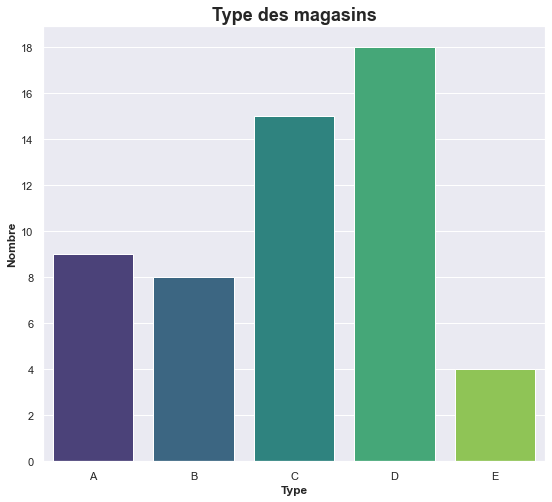

In [366]:
plt.figure(figsize=(9, 8))
sns.set_theme()

sns.countplot(x="type", data=stores, order=['A','B','C','D','E'], palette='viridis')

plt.title("Type des magasins", weight='bold').set_fontsize('18') 
plt.xlabel("Type", weight='bold')
plt.ylabel("Nombre", weight='bold')
plt.yticks(np.arange(0, 20, step=2))

plt.show()

Nous avons alors :

- A: 9 magasins

- B: 8 magasins

- C: 15 magasins

- D: 18 magasins

- E: 4 magasins

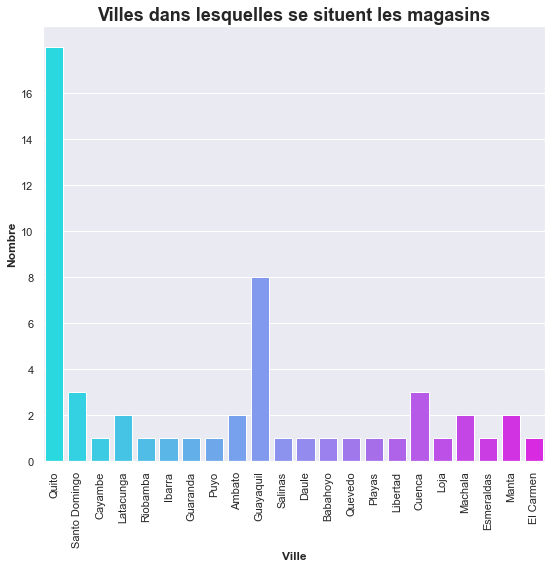

In [367]:
plt.figure(figsize=(9, 8))
sns.set_theme()

sns.countplot(x="city", data=stores, palette='cool')

plt.title("Villes dans lesquelles se situent les magasins", weight='bold').set_fontsize('18')
plt.xlabel("Ville", weight='bold')
plt.xticks(rotation='vertical')
plt.ylabel("Nombre", weight='bold')
plt.yticks(np.arange(0, 18, step=2))

plt.show()

Nous remarquons qu'une majorité des magasins se trouvent dans les villes Quito et Guayaquil. Ce résultat est cohérent : Quito et Guayaquil sont les deux villes les plus importantes de l'Equateur.

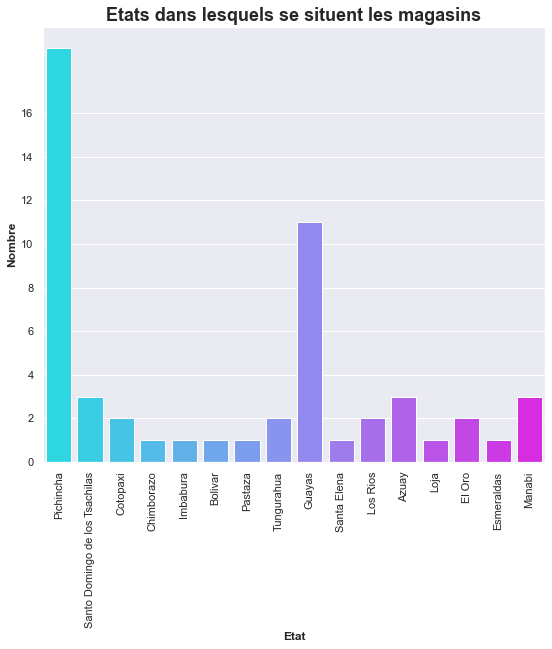

In [368]:
plt.figure(figsize=(9, 8))
sns.set_theme()

sns.countplot(x="state", data=stores, palette='cool')

plt.title("Etats dans lesquels se situent les magasins", weight='bold').set_fontsize('18')
plt.xlabel("Etat", weight='bold')
plt.xticks(rotation='vertical')
plt.ylabel("Nombre", weight='bold')
plt.yticks(np.arange(0, 18, step=2))

plt.show()

Nous remarquons qu'une majorité des magasins se trouvent dans les états Pichincha et Guayas. Ces résultats sont cohérents car, au vu des résultats de l'histogramme, la majorité des magasins se trouvent dans les villes Quito et Guayaquil, or les états de ces deux villes sont respectivement Pichincha et Guayas.

### 1.2 Transactions

In [369]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


Ce jeu de données contient des informations sur les transactions, dont :

- **date:** une date

- **store_nbr:** le numéro d'un magasin

- **transactions:** le nombre de transactions pour cette date et pour ce magasin

In [370]:
transactions.shape

(83488, 3)

In [371]:
transactions.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

Nous allons maintenant convertir la date de string à datetime afin de faciliter la visualisation des données.

In [372]:
transactions['date'] = pd.to_datetime(transactions['date'],format = '%Y-%m-%d', errors = 'coerce')

#### Exploration des données

Réalisons maintenant des résumés statistiques et des graphiques des variables du jeu de données **transactions** afin de comprendre leur répartition.

In [373]:
transactions.describe()

,store_nbr,transactions
count,83488.000,83488.000
mean,26.939,1694.602
std,15.608,963.287
min,1.000,5.000
25%,13.000,1046.000
50%,27.000,1393.000
75%,40.000,2079.000
max,54.000,8359.000


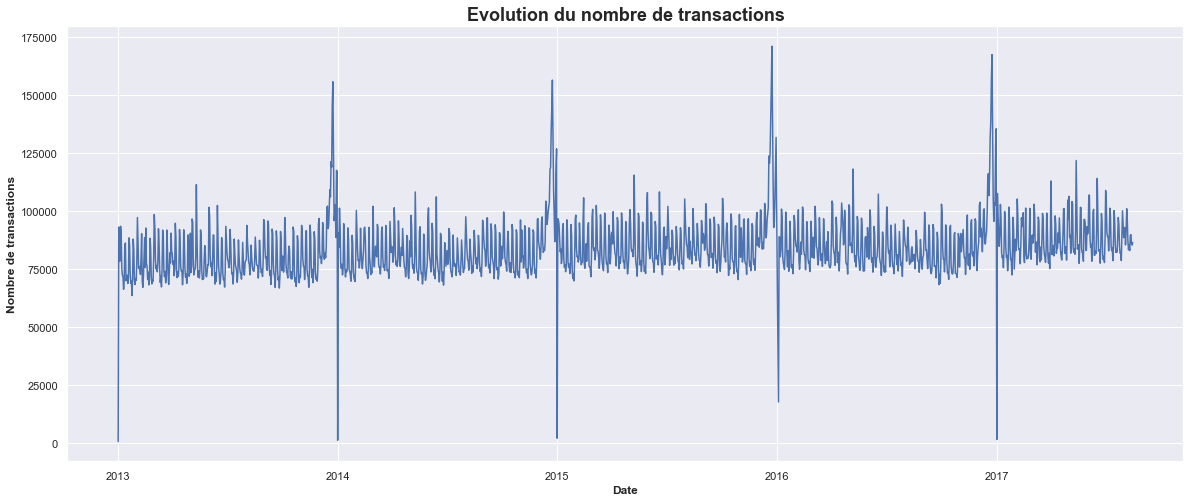

In [374]:
# Création d'un dataframe contenant le nombre de transactions par jour (tous magasins confondus)
trans_day = transactions[['date', 'transactions']].groupby(by = 'date').sum()

plt.figure(figsize=(20, 8))
sns.set_theme()

sns.lineplot(x="date", y="transactions", data=trans_day)

plt.title("Evolution du nombre de transactions", weight='bold').set_fontsize('18')
plt.xlabel("Date", weight='bold')
plt.ylabel("Nombre de transactions", weight='bold')

plt.show()

Nous observons des pics chaque année juste avant les fêtes de fin d'année et aucune transaction en début d'année, le 1er Janvier (il s'agit d'un jour férié pendant lequel personne ne travaille).

### 1.3 Sales

In [375]:
sales.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0


Ce jeu de données comprend des informations sur les ventes, dont :
- **store_nbr:** le numéro d'un magasin

- **date:** une date

- **family:** une catégorie de produits

- **sales:** la somme totale de produits vendus pour ce magasin, à cette date et pour cette catégorie de produits

- **onpromotion:** la somme totale remise par le biais de promotions

In [376]:
sales.shape

(3000888, 6)

Certaines catégories de produis de la table **sales** sont redondates (notamment "GROCERIES I" et "GROCERIES II") : nous les regroupons donc afin de réduire leur nombre.

In [377]:
sales['family'].replace(['AUTOMOTIVE', 'HARDWARE', 'LAWN AND GARDEN', 'PLAYERS AND ELECTRONICS'], 'Tools', inplace = True)
sales['family'].replace(['BEAUTY', 'LINGERIE', 'LADIESWEAR','PERSONAL CARE','CELEBRATION','MAGAZINES','BOOKS', 'BABY CARE'], 'LifeStyle', inplace = True)
sales['family'].replace(['HOME APPLIANCES','HOME AND KITCHEN I', 'HOME AND KITCHEN II','HOME CARE','SCHOOL AND OFFICE SUPPLIES', 'CLEANING', 'PRODUCE'], 'Home', inplace=True)
sales['family'].replace([ 'GROCERY II', 'PET SUPPLIES','SEAFOOD','LIQUOR,WINE,BEER', 'BEVERAGES', 'BREAD/BAKERY', 'DAIRY', 'FROZEN FOODS', 'GROCERY I', 'MEATS',
       'POULTRY', 'PREPARED FOODS'], 'Food', inplace=True)
sales['family'].replace(['DELI', 'EGGS'], 'Daily', inplace=True)

Nous réarrangeons la table **sales** afin de regrouper les ventes et promotions par catégorie (de plus que par date et magasin), après avoir regroupé certaines catégories entre elles.

In [378]:
sales = sales.groupby(by = ['date','store_nbr','family']).sum()
# on rétablie les colonnes date, store_nbr et family, qui sont devenues les index de la table après le group by :
sales = sales.rename_axis(['date', 'store_nbr', 'family']).reset_index() 

In [379]:
sales.isna().sum()

date           0
store_nbr      0
family         0
id             0
sales          0
onpromotion    0
dtype: int64

Nous n'avons pas de valeurs manquantes dans nos données. Cependant, certaines lignes de la table représentent aucune vente, nous les supprimons car il est inutile de les garder.

In [380]:
sales = sales[sales['sales'] != 0]  # suppression des lignes ne représentant aucune vente

On convertit la date en datetime pour les mêmes raisons que pour la table **transactions**:

In [381]:
sales['date'] = pd.to_datetime(sales['date'],format='%Y-%m-%d',errors='coerce')

#### Exploration des données

Réalisons maintenant des résumés statistiques et des graphiques des variables du jeu de données **sales** afin de comprendre leur répartition.

In [382]:
sales.describe().apply(lambda s: s.apply('{0:.5f}'.format)) # fonction apply afin d'éviter les écritures scientifiques

,store_nbr,id,sales,onpromotion
count,417042.00000,417042.00000,417042.00000,417042.00000
mean,26.94020,10231545.44261,2574.42884,18.72862
std,15.61760,8357968.65831,4741.34277,46.09387
min,1.00000,1141.00000,1.00000,0.00000
25%,13.00000,3620849.00000,156.00000,0.00000
50%,27.00000,7914075.00000,480.77750,0.00000
75%,40.00000,15518021.00000,3031.36550,10.00000
max,54.00000,36010473.00000,131179.44800,1455.00000


In [383]:
sales.describe(include='O')

,family
count,417042
unique,5
top,Home
freq,83606


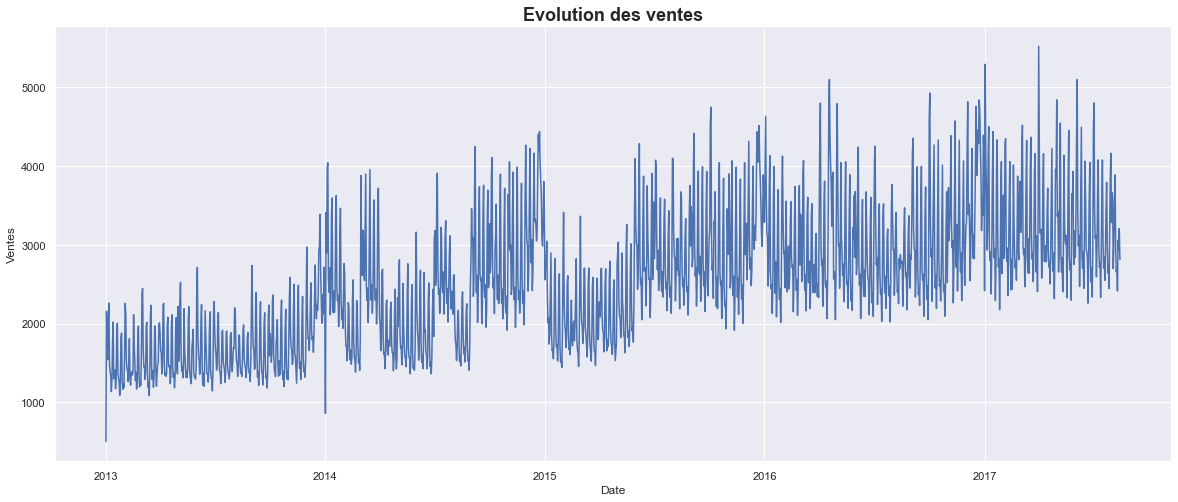

In [384]:
plt.figure(figsize=(20, 8))
sns.set_theme()

sns.lineplot(x='date', y='sales', data=sales, ci=None, estimator='mean')
plt.title("Evolution des ventes", weight='bold').set_fontsize('18')
plt.ylabel("Ventes")
plt.xlabel("Date")

plt.show()

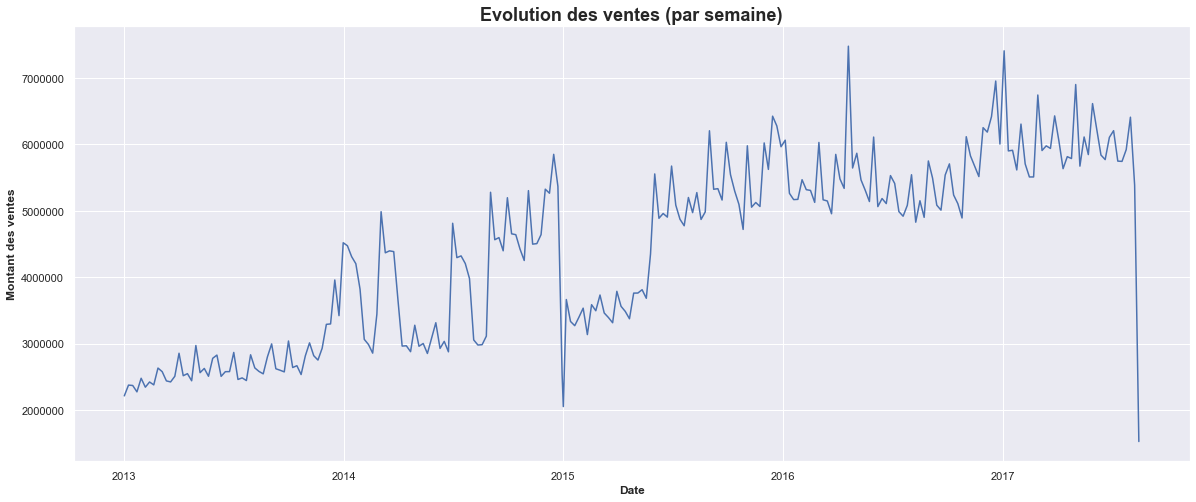

In [385]:
# Création d'un dataframe contenant le montant des ventes par semaines (tous magasins confondus et toutes catégories confondues)
sales_weekly = sales.copy()
sales_weekly['date'] = sales_weekly['date'].dt.strftime("%Y-%W-2") # On ne garde que l'année et le numéro de la semaine (2 est le numéro de jour dans la semaine par défaut)
sales_weekly['date'] = pd.to_datetime(sales_weekly['date'], format='%Y-%W-%w')

sales_per_week = sales_weekly[['date', 'sales']].groupby(by = sales_weekly['date']).sum()

plt.figure(figsize=(20, 8))
sns.set_theme()

sns.lineplot(x="date", y="sales", data=sales_per_week)

plt.title("Evolution des ventes (par semaine)", weight='bold').set_fontsize('18')
plt.xlabel("Date", weight='bold')
plt.ylabel("Montant des ventes", weight='bold')

plt.show()

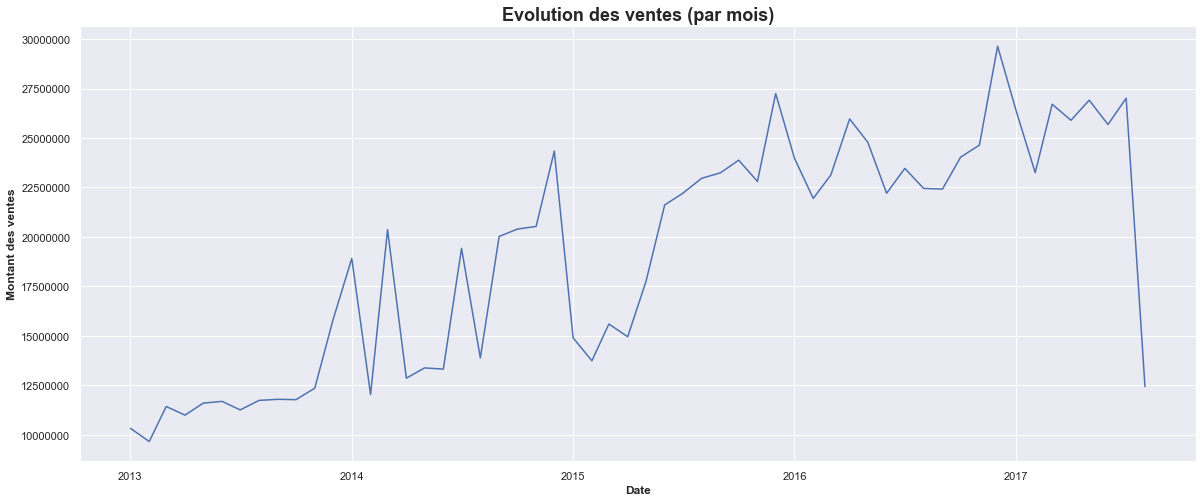

In [386]:
# Création d'un dataframe contenant le montant des ventes par mois (tous magasins confondus et toutes catégories confondues)
sales_monthly = sales.copy()
sales_monthly['date'] = sales_monthly['date'].dt.strftime("%Y-%m-1") # On ne garde que l'année et le mois (1 est le numéro de jour dans le mois par défaut)
sales_monthly['date'] = pd.to_datetime(sales_monthly['date'], format='%Y-%m-%d')

sales_per_month = sales_monthly[['date', 'sales']].groupby(by = sales_monthly['date']).sum()

plt.figure(figsize=(20, 8))
sns.set_theme()

sns.lineplot(x="date", y="sales", data = sales_per_month)

plt.title("Evolution des ventes (par mois)", weight='bold').set_fontsize('18')
plt.xlabel("Date", weight='bold')
plt.ylabel("Montant des ventes", weight='bold')

plt.show()

Nous remarquons une croissance des ventes aux cours des années. De plus, nous constatons des pics pendant les fêtes de fin d'années.

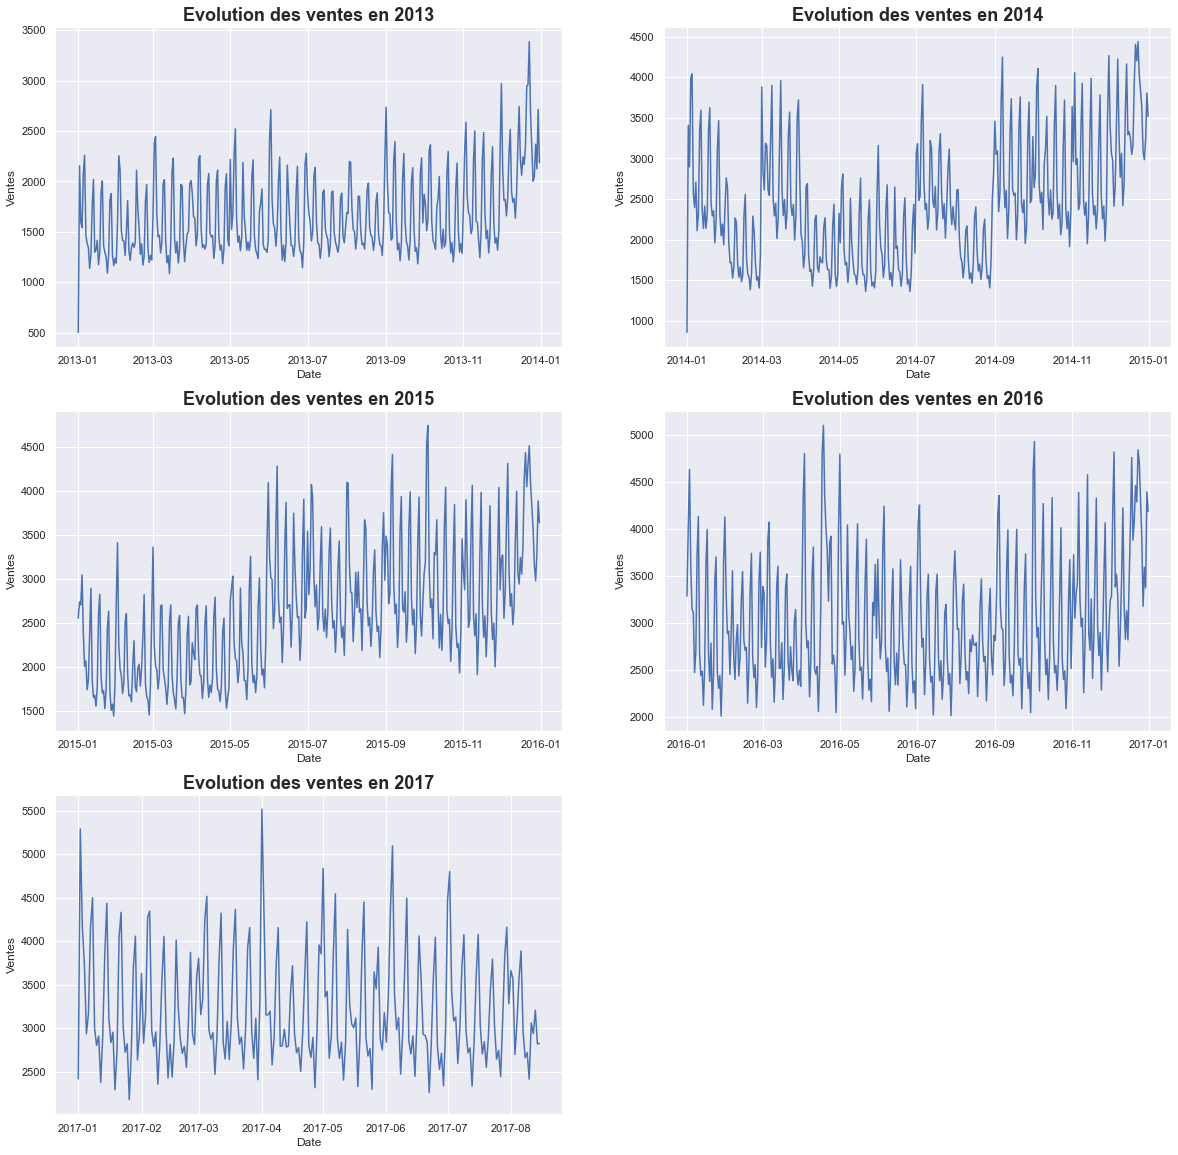

In [387]:
years = sales['date'].dt.year.unique()

plt.figure(figsize=(20, 20))
sns.set_theme()

i = 1

for y in years:
    plt.subplot(ceil(len(years)/2), 2, i)
    sns.lineplot(x='date', y='sales', data=sales[sales['date'].dt.year == y], ci=None, estimator='mean')
    plt.title("Evolution des ventes en " + str(y), weight='bold').set_fontsize('18')
    plt.ylabel("Ventes")
    plt.xlabel("Date")
    i+=1    
plt.show()

Cependant, les observations sont ne sont plus visibles, notamment celle sur les pics en Décembre, lorsque l'on trace un graphe par année.

C:\Users\alici\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


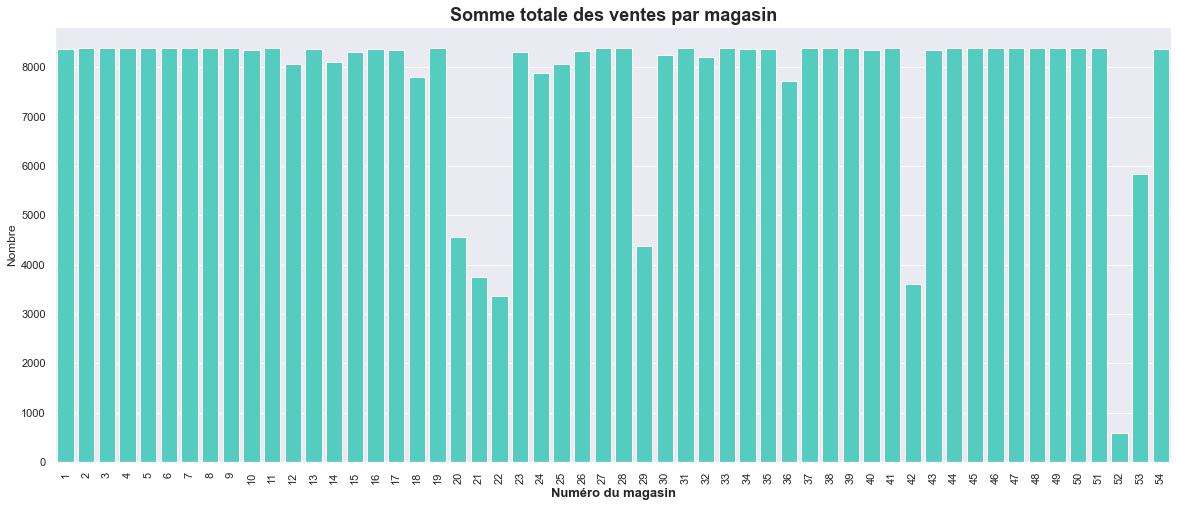

In [388]:
plt.figure(figsize=(20, 8))
sns.set_theme()

sns.countplot(sales.loc[sales['sales']!=0, 'store_nbr'], color = "turquoise") 

plt.xticks(rotation = "vertical") 
plt.title("Somme totale des ventes par magasin", weight='bold').set_fontsize('18') 
plt.xlabel("Numéro du magasin", weight='bold').set_fontsize('13') 
plt.ylabel("Nombre") 

plt.show()

Nous remarquons que le montant des ventes par magasin est plutôt constant (aux alentours de 40 000). Il y a quelques exceptions pour lesquels le montant est très inférieur.

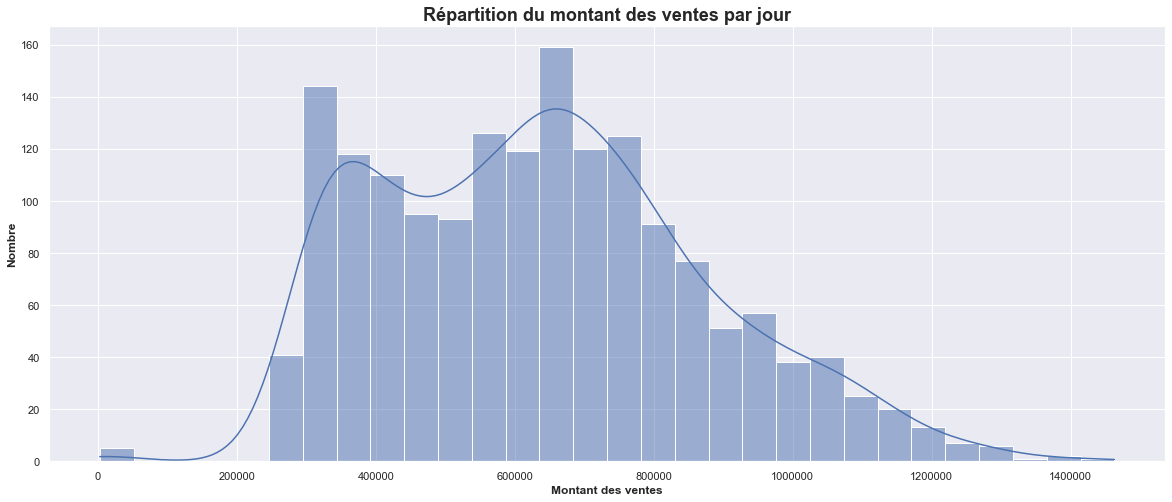

In [389]:
sales_per_day = sales[['date','sales','onpromotion']].groupby(by = 'date').sum()

plt.figure(figsize=(20, 8))
sns.set_theme()

sns.histplot(data = sales_per_day, x = "sales", kde = True, bins = 30)

plt.title("Répartition du montant des ventes par jour", weight='bold').set_fontsize('18')
plt.xlabel("Montant des ventes", weight='bold')
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False) # afin de ne pas avoir les graduations en notation scientifique
plt.ylabel("Nombre", weight='bold')

plt.show()

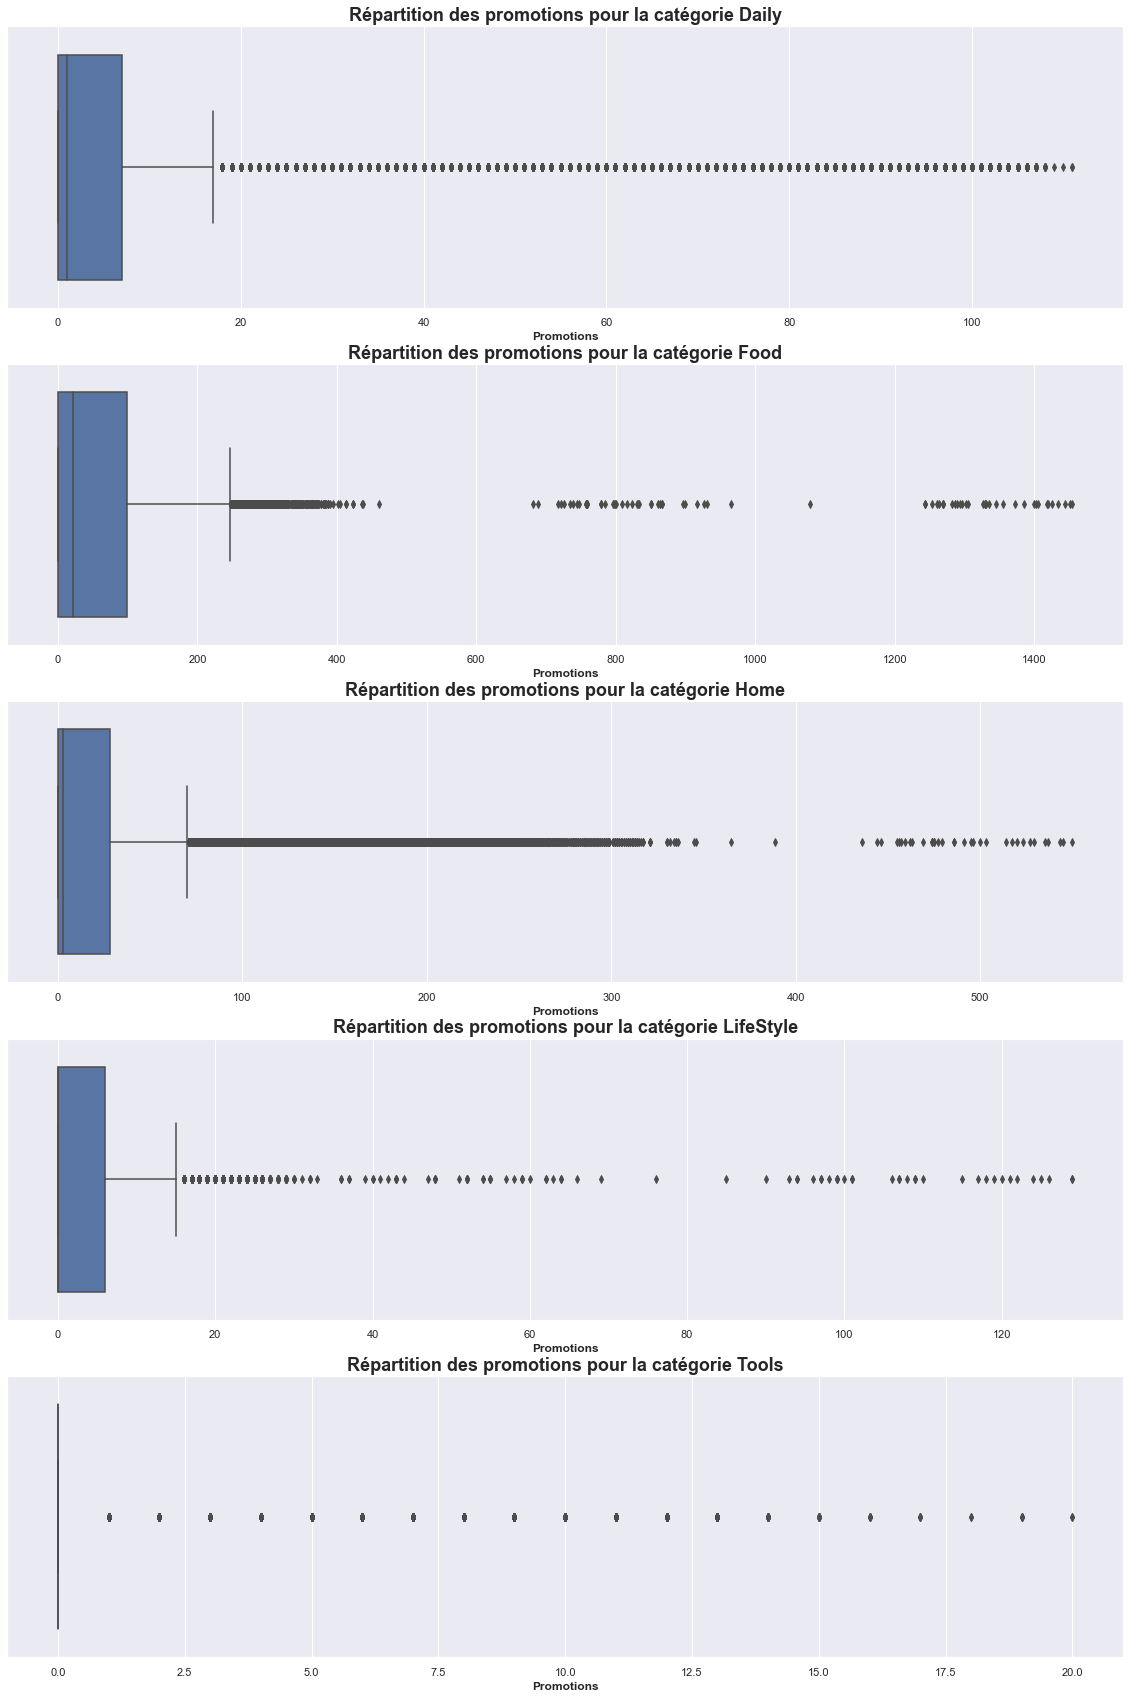

In [390]:
cats = sales['family'].unique()

plt.figure(figsize=(20, 30))
sns.set_theme()

i = 1

for c in cats:
    plt.subplot(len(cats), 1, i)
    sns.boxplot(x='onpromotion', data=sales[sales['family'] == c])
    plt.title("Répartition des promotions pour la catégorie " + str(c), weight='bold').set_fontsize('18')
    plt.xlabel("Promotions", weight='bold')
    i+=1    
    
plt.show()

Nous observons que les outils sont très peu en promotion.

C:\Users\alici\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


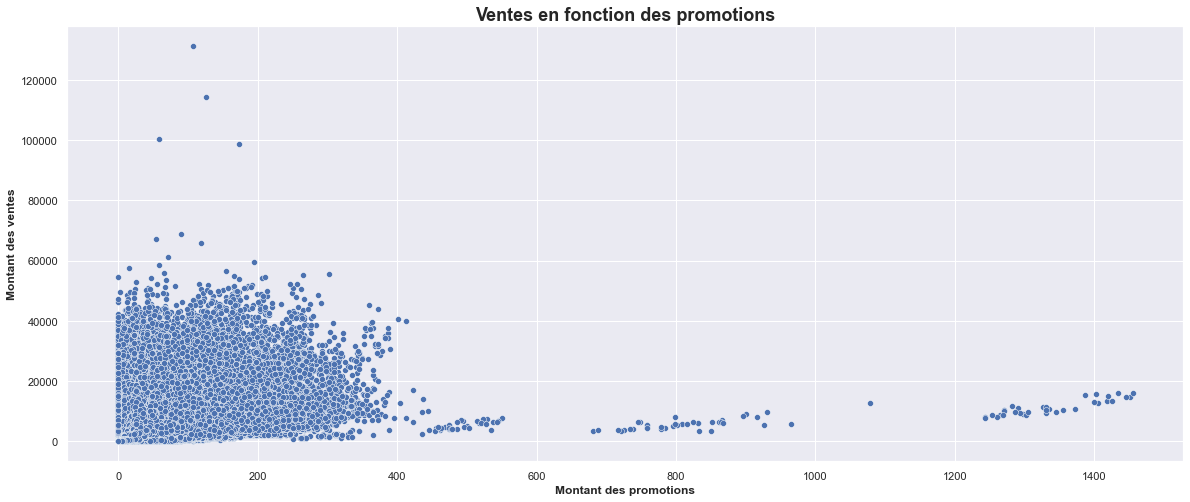

In [391]:
plt.figure(figsize=(20, 8))
sns.set_theme()

sns.scatterplot(sales['onpromotion'], sales['sales'])

plt.title("Ventes en fonction des promotions", weight='bold').set_fontsize('18')
plt.ylabel("Montant des ventes", weight='bold')
plt.xlabel("Montant des promotions", weight='bold')

plt.show()

Nous ne remarquons aucune corrélation entre le montant des promotions et les ventes.

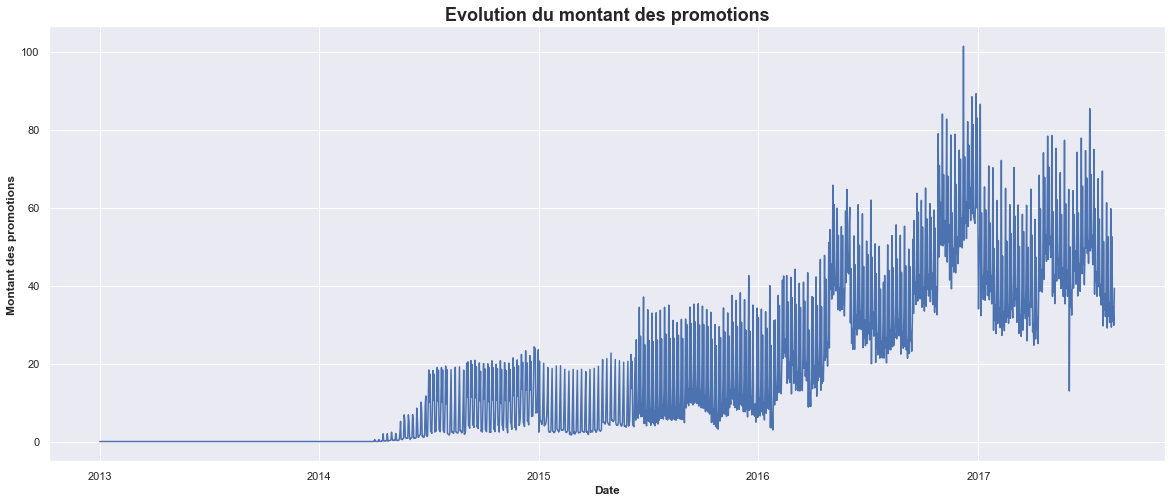

In [392]:
plt.figure(figsize=(20, 8))
sns.set_theme()

sns.lineplot(x='date',y='onpromotion', data=sales, ci=None, estimator='mean')

plt.title("Evolution du montant des promotions", weight='bold').set_fontsize('18')
plt.xlabel("Date", weight='bold')
plt.ylabel("Montant des promotions", weight='bold')

plt.show()

Nous observons une augmentation du montant des promotions depuis 2013 (de 0 à presque 80 pour les valeurs les plus élevées en 2017).

### 1.4 Holidays_events

In [393]:
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


Ce jeu de données comprend des informations sur les fêtes nationales et les jourq fériés, dont :
- **date:** la date du jours férié

- **type:** le type de jours férié

- **locale:** si le jour se fête dans tout le pays ou seulement dans certaines régions ou dans certaines villes

- **locale_name:** l'endroit dans lequel se fête le jour férié (une ville, une région ou l'Equateur).

- **description:** le nom de la célébration

- **transferred:** si le jour a été déplacé à une autre date

In [394]:
holidays_events.shape

(350, 6)

In [395]:
holidays_events.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [396]:
holidays_events['date'] = pd.to_datetime(holidays_events['date'], format='%Y-%m-%d',errors='coerce')

#### Exploration des données

Réalisons maintenant des résumés statistiques et des graphiques des variables du jeu de données **holidays_events** afin de comprendre leur répartition.

In [397]:
holidays_events.describe(include = 'object')

,type,locale,locale_name,description
count,350,350,350,350
unique,6,3,24,103
top,Holiday,National,Ecuador,Carnaval
freq,221,174,174,10


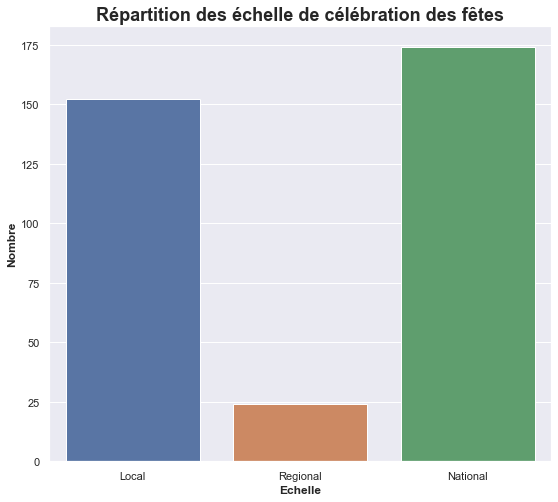

In [398]:
plt.figure(figsize=(9, 8))
sns.set_theme()

sns.countplot(x="locale", data=holidays_events)

plt.title("Répartition des échelle de célébration des fêtes", weight='bold').set_fontsize('18')
plt.xlabel("Echelle", weight='bold')
plt.ylabel("Nombre", weight='bold')

plt.show()

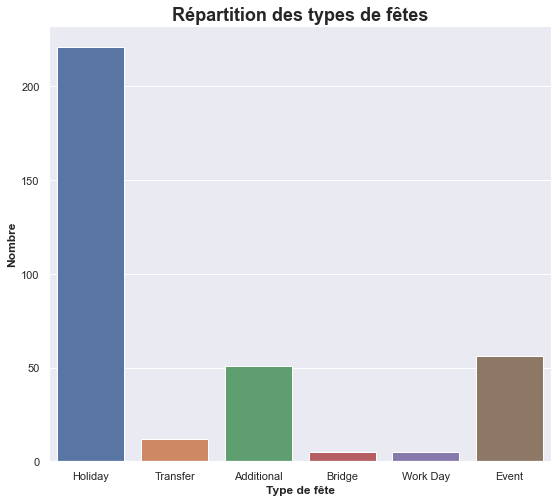

In [399]:
plt.figure(figsize=(9, 8))
sns.set_theme()

sns.countplot(x="type", data=holidays_events)

plt.title("Répartition des types de fêtes", weight='bold').set_fontsize('18')
plt.xlabel("Type de fête", weight='bold')
plt.ylabel("Nombre", weight='bold')
plt.show()

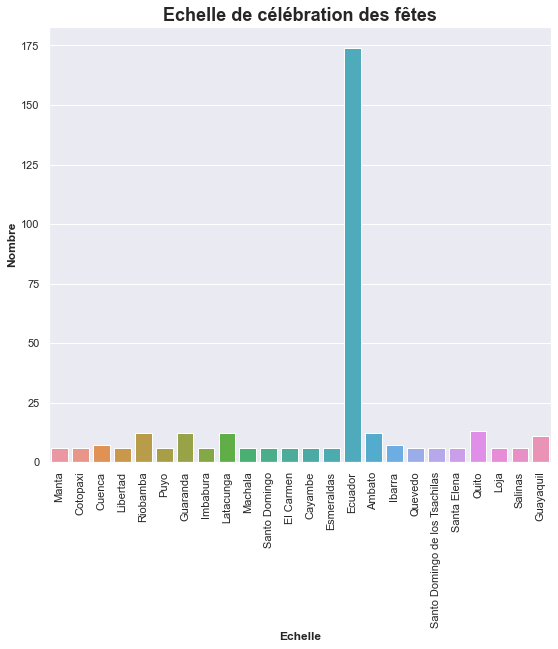

In [400]:
plt.figure(figsize=(9, 8))
sns.set_theme()

sns.countplot(x="locale_name", data=holidays_events)

plt.title("Echelle de célébration des fêtes", weight='bold').set_fontsize('18')
plt.xlabel("Echelle", weight='bold')
plt.xticks(rotation = 90)
plt.ylabel("Nombre", weight='bold')

plt.show()

Des graphes précédents, nous tirons les remarques suivantes : la plupart des fêtes sont de niveau national, donc célébrées partout en Equateur, ou bien régionales. Une grande majorité de ces fêtes sont des jours fériés pendant lesquels les gens ne travaillent pas. Il est intéressant de noter que la célébration ayant le plus d'occurences dans la table est le carnaval (fêté dans tout le pays) : sa célébration dure deux jours consécutifs.

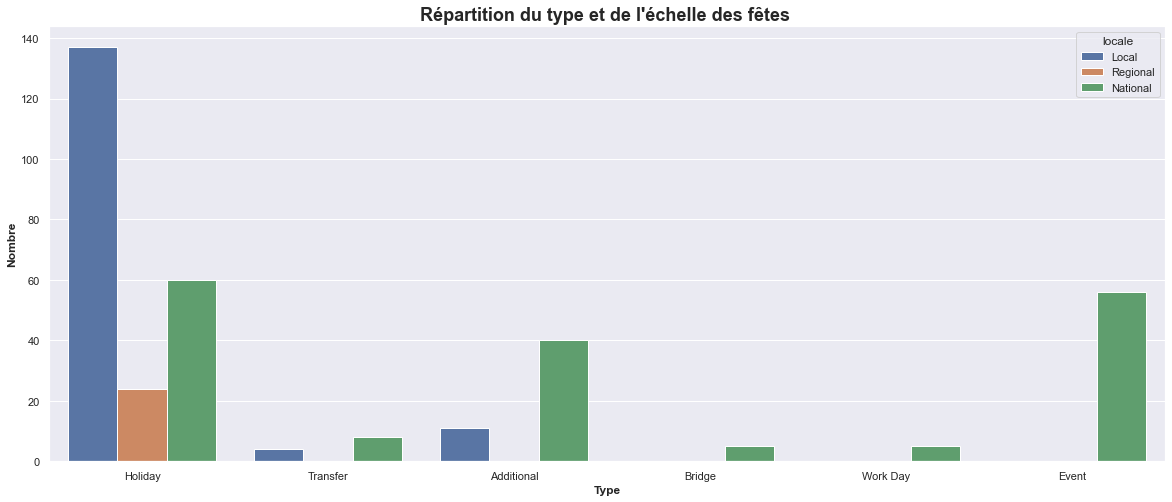

In [401]:
plt.figure(figsize=(20, 8))
sns.set_theme()

sns.countplot(x="type", hue="locale", data=holidays_events)

plt.title("Répartition du type et de l'échelle des fêtes ", weight='bold').set_fontsize('18')
plt.xlabel("Type", weight='bold')
plt.ylabel("Nombre", weight='bold')

plt.show()

### 1.5 Oil

In [402]:
oil.head()

,date,dcoilwtico
0,2013-01-01,nan
1,2013-01-02,93.140
2,2013-01-03,92.970
3,2013-01-04,93.120
4,2013-01-07,93.200


Ce jeu de données comprend le prix de l'huile quotidien (l'Equateur est un pays dépendant de l'huile et son économie est vulnérable aux changements soudains du prix de l'huile).

In [403]:
oil.shape

(1218, 2)

In [404]:
oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

Certaines valeurs sont manquantes, nous les remplaçons avec deux techniques différentes : l'interpolation linéaire et la méthode "Next Observartion Carried Backward". La première consiste à utiliser la fonction affine passant par les deux points de par et d'autre de la valeur manquante pour remplacer cette dernière. La deuxième consiste à remplacer la valeur manquante par l'observation se situant après.

In [405]:
# Computation des valeurs manquantes

# Linear interpolation
oil.interpolate(method='linear', inplace=True)
# Next Observartion Carried Backward
oil['dcoilwtico'].fillna(method='backfill', inplace=True)

On convertit encore une fois les dates en datetime :

In [406]:
oil['date'] = pd.to_datetime(oil['date'],format='%Y-%m-%d',errors='coerce')

#### Exploration des données

Réalisons maintenant des résumés statistiques et des graphiques des variables du jeu de données **oil** afin de comprendre leur répartition.

In [407]:
oil.describe()

,dcoilwtico
count,1218.000
mean,67.683
std,25.633
min,26.190
25%,46.422
50%,53.185
75%,95.685
max,110.620


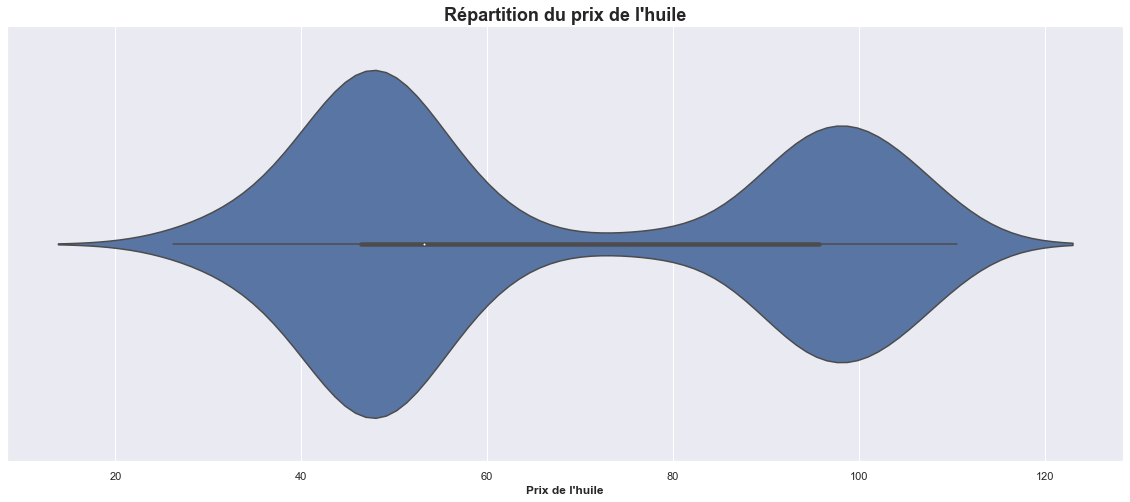

In [408]:
sns.set_theme()
plt.figure(figsize=(20, 8))

sns.violinplot(data=oil, x='dcoilwtico')

plt.title("Répartition du prix de l'huile", weight='bold').set_fontsize('18')
plt.xlabel("Prix de l'huile", weight='bold')

plt.show()

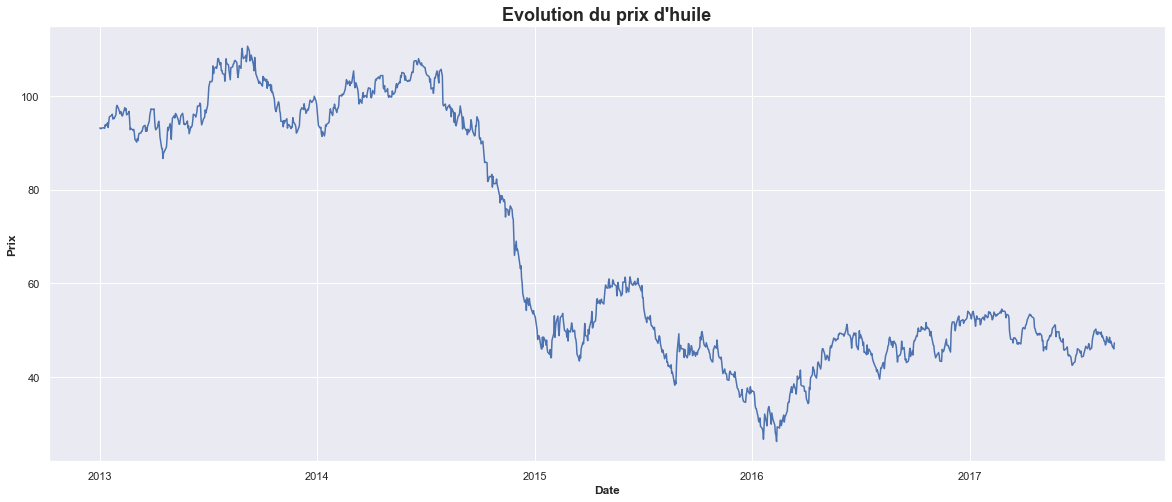

In [409]:
sns.set_theme()
plt.figure(figsize = (20, 8)) 

sns.lineplot(x='date', y='dcoilwtico', data=oil, ci=None, estimator='mean')

plt.title("Evolution du prix d'huile", weight='bold').set_fontsize('18')
plt.ylabel("Prix", weight='bold')
plt.xlabel("Date", weight='bold')

plt.show()

Nous remarquons que le prix de l'huile a considérablement diminué, surtout en 2014.

## 2. Construction du dataframe

Nous effectuons ensuite la jointure de toutes ces tables afin de constituer le dataframe qui va faire l'objet de la modélisation.

In [410]:
# Jointures des tables (inner joins)
df = pd.merge(stores, sales, on = 'store_nbr')
df = pd.merge(df, transactions, on = ['date','store_nbr'])
df = pd.merge(df, holidays_events, on = 'date')
df = pd.merge(df, oil, on = 'date')

NB : après jointure des tables, aucune valeur manquante n'est présente dans le dataframe (car il s'agit de jointures internes)

Nous obtenons au final :

In [411]:
df.head()

,store_nbr,city,state,type_x,cluster,date,family,id,sales,onpromotion,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,1,Quito,Pichincha,D,13,2013-02-11,Daily,146143,72.321,0,396,Holiday,National,Ecuador,Carnaval,False,97.010
1,1,Quito,Pichincha,D,13,2013-02-11,Food,876957,1089.429,0,396,Holiday,National,Ecuador,Carnaval,False,97.010
2,1,Quito,Pichincha,D,13,2013-02-11,Home,511568,152.000,0,396,Holiday,National,Ecuador,Carnaval,False,97.010
3,1,Quito,Pichincha,D,13,2013-02-11,LifeStyle,584597,23.000,0,396,Holiday,National,Ecuador,Carnaval,False,97.010
4,1,Quito,Pichincha,D,13,2013-02-11,Tools,292309,8.000,0,396,Holiday,National,Ecuador,Carnaval,False,97.010


In [412]:
df.shape

(48721, 17)

## 3. Statistiques exploratoires des tables jointes

In [413]:
df.describe()

,store_nbr,cluster,id,sales,onpromotion,transactions,dcoilwtico
count,48721.000,48721.000,48721.000,48721.000,48721.000,48721.000,48721.000
mean,26.995,8.533,11120169.512,2686.205,24.636,1735.185,63.618
std,15.601,4.714,8232767.129,5024.255,57.559,1050.608,24.829
min,1.000,1.000,1141.000,1.000,0.000,54.000,27.960
25%,13.000,4.000,4351461.000,157.000,0.000,1031.000,44.880
50%,27.000,9.000,8836273.000,481.000,1.000,1410.000,51.980
75%,40.000,13.000,16463504.000,3216.039,16.000,2149.000,94.090
max,54.000,17.000,36010473.000,131179.448,1405.000,8359.000,107.950


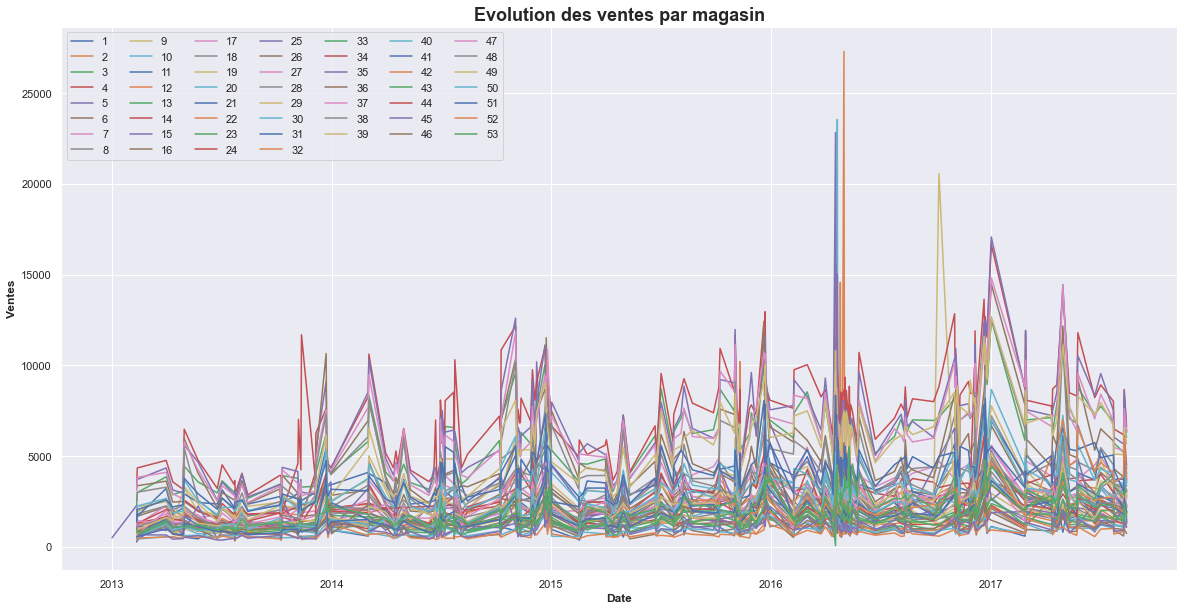

In [414]:
plt.figure(figsize=(20,10))

for i in range(1,54):
    df_i = df.loc[(df['store_nbr'] == i)]
    sns.lineplot(x='date',y='sales',data=df_i,ci=None,estimator='mean',label=i)
    
plt.title("Evolution des ventes par magasin", weight='bold').set_fontsize('18')
plt.legend(loc="upper left", ncol=7)
plt.xlabel("Date", weight='bold')
plt.ylabel("Ventes", weight='bold')

plt.show()

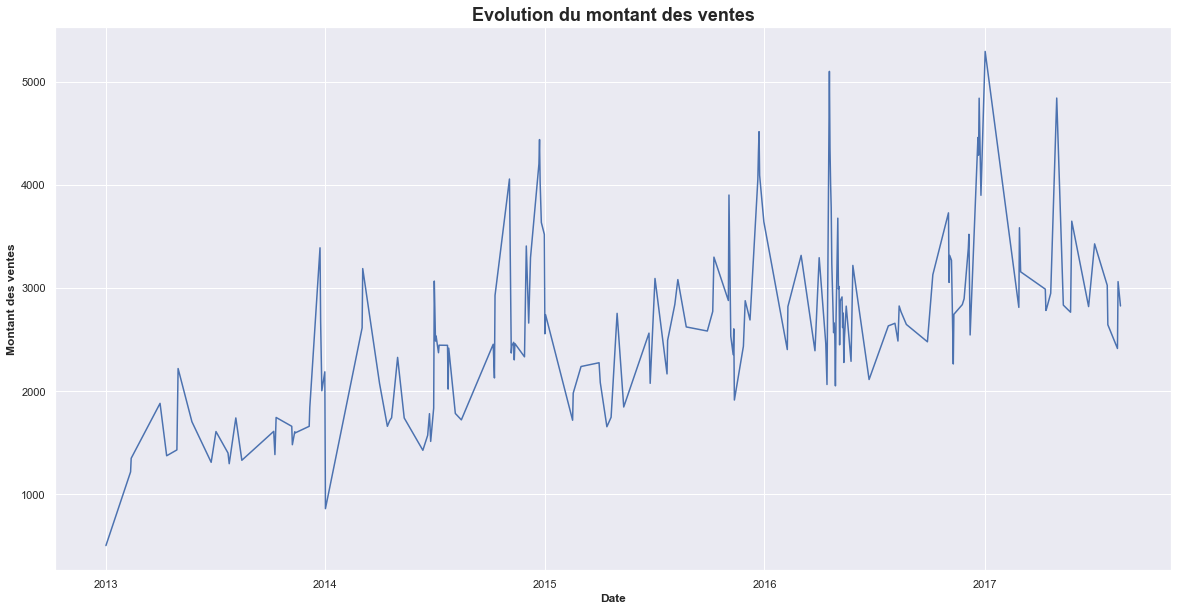

In [415]:
plt.figure(figsize = (20, 10))

sns.lineplot(x='date',y='sales',data=df,ci=None,estimator='mean')

plt.title("Evolution du montant des ventes", weight='bold').set_fontsize('18')
plt.xlabel("Date", weight='bold')
plt.ylabel("Montant des ventes", weight='bold')

plt.show()

## 4. Preprocessing des données

Nous commençons par changer le type des variables 'objet' en 'category', afin de faciliter la suite.

In [416]:
df.dtypes

store_nbr                int64
city                    object
state                   object
type_x                  object
cluster                  int64
date            datetime64[ns]
family                  object
id                       int64
sales                  float64
onpromotion              int64
transactions             int64
type_y                  object
locale                  object
locale_name             object
description             object
transferred               bool
dcoilwtico             float64
dtype: object

In [417]:
df['city'] = df['city'].astype('category')
df['state'] = df['state'].astype('category')
df['type_x'] = df['type_x'].astype('category')
df['family'] = df['family'].astype('category')
df['type_y'] = df['type_y'].astype('category')
df['locale'] = df['locale'].astype('category')
df['locale_name'] = df['locale_name'].astype('category')
df['description'] = df['description'].astype('category')

Nous obtenons enfin les dummies des variables catégorielles, c'est-à-dire :

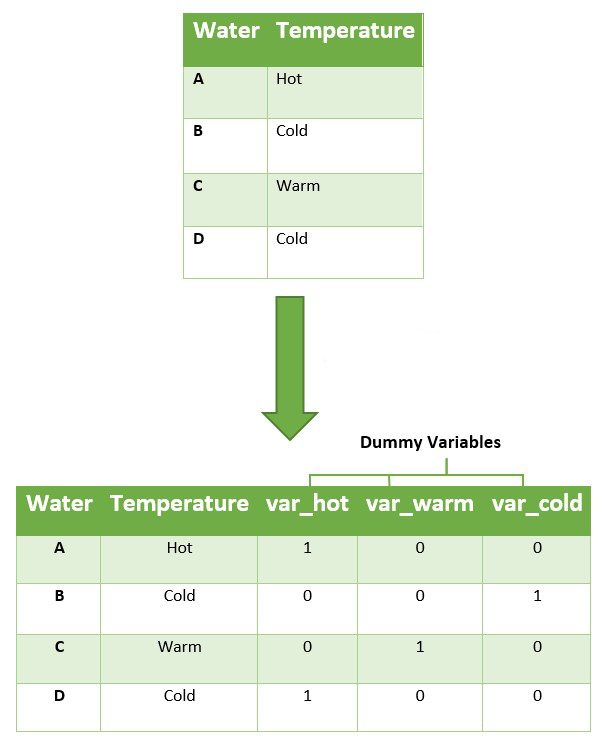

In [418]:
import requests
import IPython.display as Disp
url = 'https://media.geeksforgeeks.org/wp-content/uploads/20201210102727/Screenshot708.jpg'
Disp.Image(requests.get(url).content)

In [419]:
# Obtention des dummies
df = pd.get_dummies(df, columns = ['city','state','type_x','family','type_y','locale','locale_name','description','date'])

## 4. Modélisation et prédictions

Afin d'effectuer la prédiction de ventes, nous allons modéliser nos données. Pour cela, nous commençons par expliciter les variables explicatives et la variable à expliquer (respectivement x et y) : 

In [420]:
x = df[df.columns.drop('sales')]
y = df['sales']

Nous divisons ensuite le jeu de données en jeux de données d'apprentissage et de test (nous choissisons de prendre 70% du jeu de données initial pour entraîner notre modèle).

In [427]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7)

#### Gradient Boosting

Commençons par modéliser nos données avec un modèle de Gradient Boosting.

In [428]:
model = XGBRegressor(n_estimators=10, max_depth=20, verbosity=2)
model.fit(x_train, y_train)

[23:45:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 3354 extra nodes, 0 pruned nodes, max_depth=20
[23:45:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 5090 extra nodes, 0 pruned nodes, max_depth=20
[23:45:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6896 extra nodes, 0 pruned nodes, max_depth=20
[23:45:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 8766 extra nodes, 0 pruned nodes, max_depth=20
[23:45:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 9788 extra nodes, 0 pruned nodes, max_depth=20
[23:45:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 112

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=20, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=2)

In [429]:
model.predict(x_test)
model.score(x_test, y_test)

0.9321529861180213

In [433]:
print("Nous obtenons un score de", round(model.score(x_test, y_test), 2),"environ, ce qui est très bien ! Essayons quand même avec d'autres modèles.")

Nous obtenons un score de 0.93 environ, ce qui est très bien ! Essayons quand même avec d'autres modèles.


#### Régression linéaire

Tentons ensuite de modéliser grâce à un modèle de régression linéaire :

In [305]:
model2 = linear_model.LinearRegression()
model2.fit(x_train, y_train)

LinearRegression()

In [306]:
model2.predict(x_test)
model2.score(x_test, y_test)

0.656225006662374

Nous obtenons un score de 0.65 environ, c'est bien moins efficace que le modèle précédent.

### Modélisation avec ARMA et ARIMA

Notre but maintenant est de modéliser et prédire les ventes de la nourriture du magasin 1 avec les modèles ARMA et ARIMA.

D'abord nous allons créer une nouvelle table contenant seulement les données nécessaires en supprimant les lignes des autres magasins et produits. En plus, nous allons mettre la date comme index.

In [434]:
# Rétablissement du jeu de données initial
df = pd.merge(stores, sales, on = 'store_nbr')
df = pd.merge(df, transactions, on = ['date','store_nbr'])
df = pd.merge(df, holidays_events, on = 'date')
df = pd.merge(df, oil, on = 'date')

df2 = df[df['family'] == 'Food']
df2 = df2.drop('family', 1)
df2 = df2[df2.store_nbr == 1]
df2 = df2.drop(['store_nbr', 'city', 'state', 'type_x', 'cluster'], 1) # nous les supprimons car ces données sont constantes
df2.index = pd.to_datetime(df2['date'], format='%Y-%m-%d')
df2 = df2.drop('date', 1)
df2.head()

,id,sales,onpromotion,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
date,,,,,,,,,,
2013-02-11,876957,1089.429,0,396,Holiday,National,Ecuador,Carnaval,False,97.010
2013-02-12,898341,1493.894,0,487,Holiday,National,Ecuador,Carnaval,False,97.480
2013-04-01,1924773,4869.181,0,1894,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,97.100
2013-04-12,2159997,5113.420,0,1860,Holiday,Local,Cuenca,Fundacion de Cuenca,False,91.230
2013-04-29,2523525,3597.647,0,1653,Holiday,National,Ecuador,Viernes Santo,False,94.090


In [435]:
df2.shape

(194, 10)

Il nous reste alors 194 lignes et 10 colonnes.

Ensuite, nous allons séparer nos données en fonction de la date dans des échantillons train et test pour pouvoir évaluer nos résultats. Nous créons de plus des dataframes **x_train** et **x_test** qui contiennent toutes les colonnes sauf _sales_ et **y_train** et **y_test** qui contiennent seulement _sales_.

In [436]:
train = df2[df2.index < pd.to_datetime("2017-01-01", format='%Y-%m-%d')]
test = df2[df2.index >= pd.to_datetime("2017-01-01", format='%Y-%m-%d')]

x_train = train[train.columns.drop('sales')]
x_test = test[test.columns.drop('sales')]

y_train = train['sales']
y_test = test['sales']

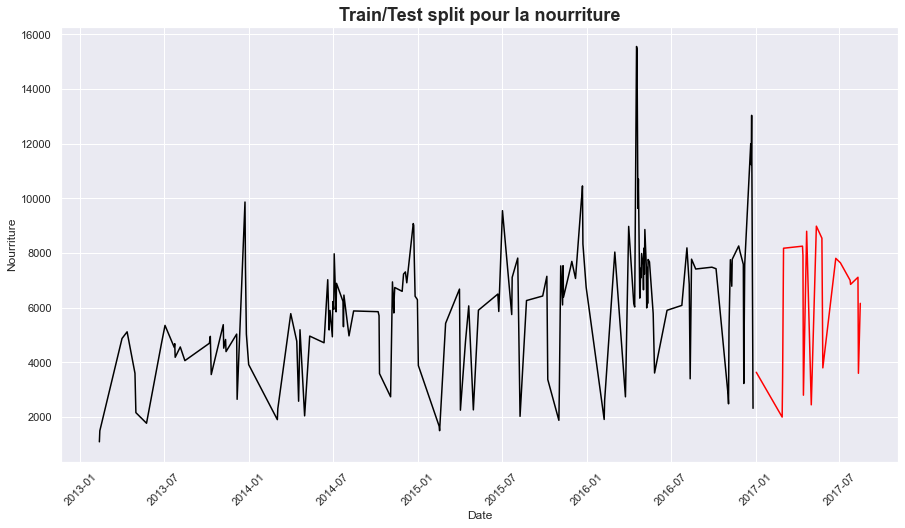

In [437]:
sns.set(rc = {'figure.figsize':(15,8)})

plt.plot(train.sales, color = "black")
plt.plot(test.sales, color = "red")

plt.ylabel('Nourriture')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split pour la nourriture", weight='bold').set_fontsize('18')

plt.show()

Regardons ensuite le graphique de ces données. Nous remarquons qu'il y a des jours manquants dans nos données et en outre, nous voyons des pics autour de Noël et le Nouvel An, mais aussi en mai 2016.

#### ARMA

En premier lieu, nous essayons de créer un modèle ARMA(p,q) pour traiter des séries temporelles. Le modèle est composé d’une part autorégressive (AR) et une part moyenne-mobile (MA). Pour cela, nous devons indiquer les ordres p d’AR et q de MA.

In [438]:
from statsmodels.tsa.statespace.sarimax import SARIMAX #ARMA

In [439]:
ARMAmodel = SARIMAX(y_train, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

C:\Users\alici\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\alici\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\alici\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\alici\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an int

Nos prédicitons:

In [440]:
y_pred_out

date
2017-01-02   7036.621
2017-02-27   6932.324
2017-02-28   6829.572
2017-03-02   6728.344
2017-04-12   6628.616
2017-04-13   6530.367
2017-04-14   6433.573
2017-04-14   6338.215
2017-04-21   6244.269
2017-05-01   6151.717
2017-05-12   6060.536
2017-05-24   5970.706
2017-05-26   5882.208
2017-06-23   5795.022
2017-07-03   5709.128
2017-07-03   5624.507
2017-07-24   5541.140
2017-07-25   5459.009
2017-08-10   5378.095
2017-08-11   5298.381
2017-08-15   5219.848
Name: Predictions, dtype: float64

Le graphique de nos prédictions (en vert) :

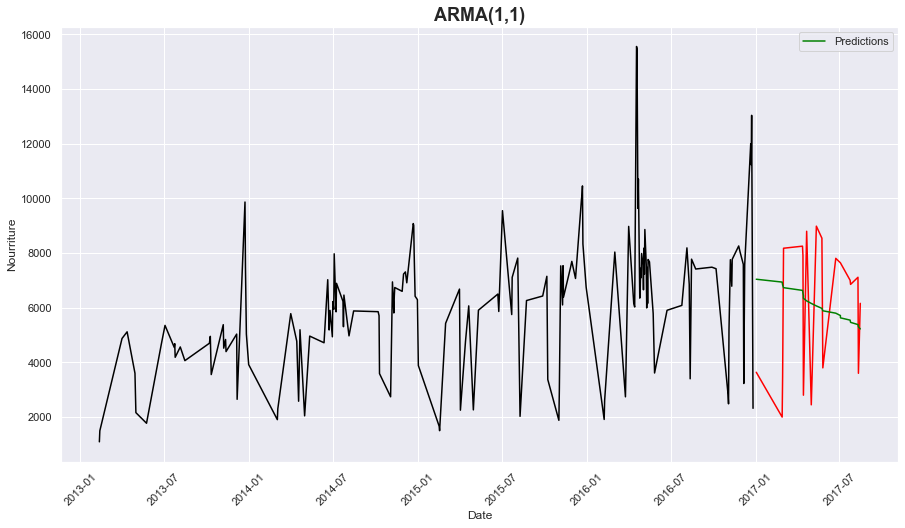

In [441]:
plt.plot(train.sales, color = "black")
plt.plot(test.sales, color = "red")

plt.ylabel('Nourriture')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("ARMA(1,1)", weight='bold').set_fontsize('18')

plt.plot(y_pred_out, color='green', label = 'Predictions')

plt.legend()

plt.show()

In [442]:
print(ARMAmodel.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  173
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1578.982
Date:                Sun, 19 Dec 2021   AIC                           3163.964
Time:                        23:48:07   BIC                           3173.424
Sample:                             0   HQIC                          3167.802
                                - 173                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9852      0.012     80.646      0.000       0.961       1.009
ma.L1         -0.5220      0.061     -8.617      0.000      -0.641      -0.403
sigma2      5.045e+06    1.9e-09   2.66e+15      0.0

Le résumé de nos résultats donne une colonne **coef** qui représente l’importance et l’impact sur la série. La colonne **P> |z|** montre la signifiance du **coef**. Ici, toutes les valeurs sont significatives, alors, il faudrait tout laisser dans le modèle.

In [443]:
#calcul rmse
from math import sqrt
from sklearn.metrics import mean_squared_error

rms = sqrt(mean_squared_error(test.sales, y_pred_out))
print(rms)

2600.166773517264


Cependant, le Root Mean Squared Error (RMSE) est très élévé. Le modèle ne représente alors pas bien nos données (ce que nous avons déjà vu dans le graphique).

#### ARIMA

En second lieu, nous analysons le modèle **ARIMA(p,d,q)**. Il est proche du modèle précédent mais celui-là est utilisé pour les séries non-stationnaires. On ne modélise pas d soi-même pas la d-ème différence.

Essayons maintenant de modéliser nos données avec les paramètres p=2, d=1 et q=2.

In [444]:
from statsmodels.tsa.arima_model import ARIMA

In [445]:
ARIMAmodel = ARIMA(y_train, order = (2, 1, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

C:\Users\alici\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\alici\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

AttributeError: 'ARIMAResults' object has no attribute 'get_forecast'

In [ ]:
y_pred_out

Les résultats ont déjà l’air d’être moins similaires et d’osciller un peu. De plus, cela se remarque sur le graphique :

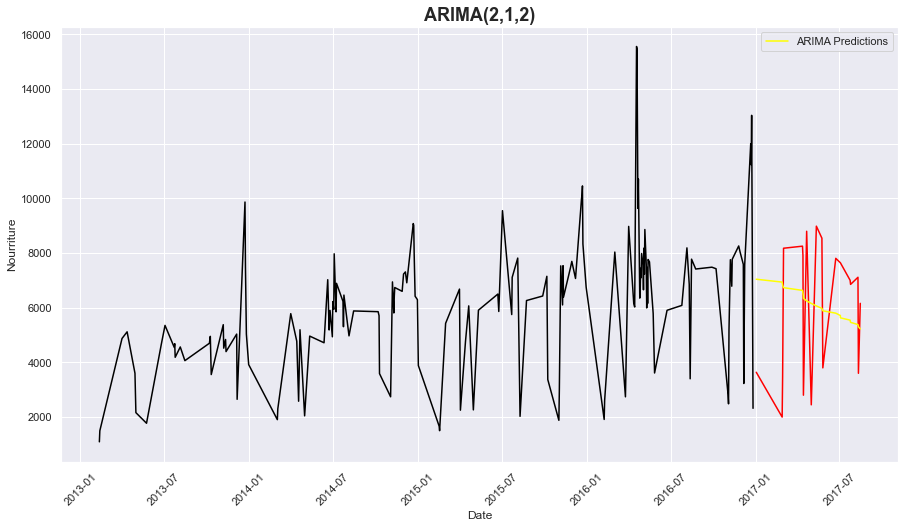

In [446]:
plt.plot(train.sales, color = "black")
plt.plot(test.sales, color = "red")

plt.ylabel('Nourriture')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("ARIMA(1,0,0)", weight='bold').set_fontsize('18')

plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')

plt.legend()

plt.show()

In [447]:
print(ARIMAmodel.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                  172
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1554.806
Method:                       css-mle   S.D. of innovations           2009.331
Date:                Sun, 19 Dec 2021   AIC                           3121.613
Time:                        23:48:09   BIC                           3140.498
Sample:                             1   HQIC                          3129.275
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            21.5971      5.564      3.881      0.000      10.691      32.503
ar.L1.D.sales    -0.4691      0.076     -6.195      0.000      -0.617      -0.321
ar.L2.D.sales     0.3904      0.075     

Pourtant, **ar.L2** n‘est pas significative. Nous pourrions alors essayer de mettre p=1 à la place.

In [448]:
rms = sqrt(mean_squared_error(test.sales, y_pred_out))
print(rms)

2600.166773517264


Même si le graphique avait l’air d’être mieux, le **rms** a aggravé.

#### AUTO ARIMA

Pour finir, à la place d’essayer toutes les combinations possibles, nous allons lancer la commande auto_arima pour trouver le meilleur modèle.

In [466]:
import pmdarima as pm
from pm import auto_arima

ImportError: cannot import name 'call_cached_func' from 'statsmodels.compat.pandas' (C:\Users\alici\anaconda3\lib\site-packages\statsmodels\compat\pandas.py)

In [450]:
model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

NameError: name 'pm' is not defined

**auto_arima** nous propose le modèle **ARIMA(1,0,0)**, donc un modèle sans prenant compte des différences. Probablement, parce que nos données étaient déjà stationnaires. Ensuite, affichons-nous ce modèle.

In [451]:
ARIMAmodel = ARIMA(y_train, order = (1, 0, 0))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

C:\Users\alici\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\alici\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

AttributeError: 'ARMAResults' object has no attribute 'get_forecast'

In [458]:
y_pred_out

date
2017-01-02   7036.621
2017-02-27   6932.324
2017-02-28   6829.572
2017-03-02   6728.344
2017-04-12   6628.616
2017-04-13   6530.367
2017-04-14   6433.573
2017-04-14   6338.215
2017-04-21   6244.269
2017-05-01   6151.717
2017-05-12   6060.536
2017-05-24   5970.706
2017-05-26   5882.208
2017-06-23   5795.022
2017-07-03   5709.128
2017-07-03   5624.507
2017-07-24   5541.140
2017-07-25   5459.009
2017-08-10   5378.095
2017-08-11   5298.381
2017-08-15   5219.848
Name: Predictions, dtype: float64

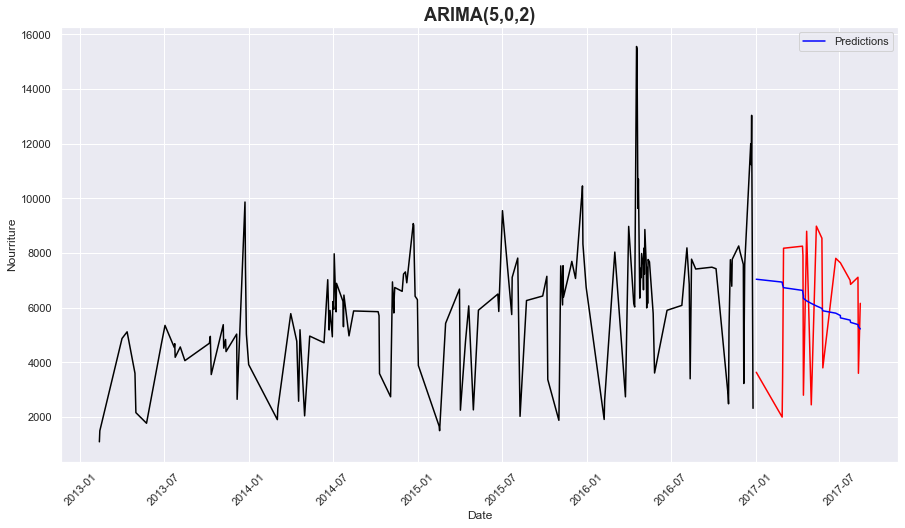

In [459]:
plt.plot(train.sales, color = "black")
plt.plot(test.sales, color = "red")

plt.ylabel('Nourriture')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("ARIMA(5,0,2)", weight='bold').set_fontsize('18')

plt.plot(y_pred_out, color='blue', label = 'Predictions')

plt.legend()

plt.show()

Les prédictions sur le graphique ont l’air d’avoir amélioré.

In [460]:
print(ARIMAmodel.summary())

                              ARMA Model Results                              
Dep. Variable:                  sales   No. Observations:                  173
Model:                     ARMA(5, 2)   Log Likelihood               -1565.953
Method:                       css-mle   S.D. of innovations           2061.165
Date:                Mon, 20 Dec 2021   AIC                           3149.906
Time:                        00:03:54   BIC                           3178.286
Sample:                             0   HQIC                          3161.420
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6097.2101    422.910     14.417      0.000    5268.323    6926.098
ar.L1.sales    -0.2083      0.536     -0.389      0.698      -1.259       0.842
ar.L2.sales    -0.1995      0.521     -0.383    

In [461]:
rms = sqrt(mean_squared_error(test.sales, y_pred_out))
print(rms)

2600.166773517264


En outre, le **rms** s'est amélioré: il est même mieux que **ARMA(1,1)**.


## Conclusion

En conclusion, nous pouvons dire que le modèle de Gradient Boosting est le meilleur modèle. Il est très efficace, comparé aux autres modèles essayés.

Même si nous sommes parvenues à nos fins, la modélisation de séries temporelles a été très difficile, n'ayant pas encore eu les cours nécessaires. De ce fait, si nous avions eu connaissance de la difficulté de la tâche nous aurions peut-être choisi un exercice qui nous aurait été plus abordable. Cependant, cela a tout de même enrichi nos connaissances.